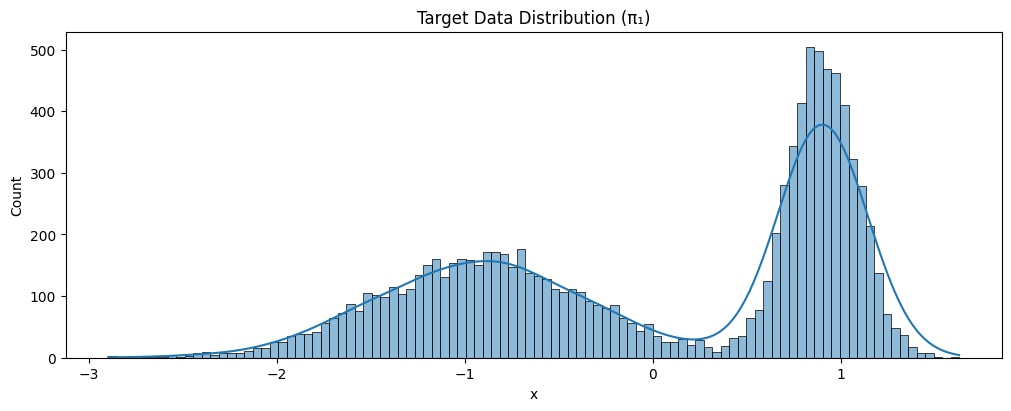

Training: 100%|██████████| 10000/10000 [00:12<00:00, 770.18iteration/s, Loss=1.3557]


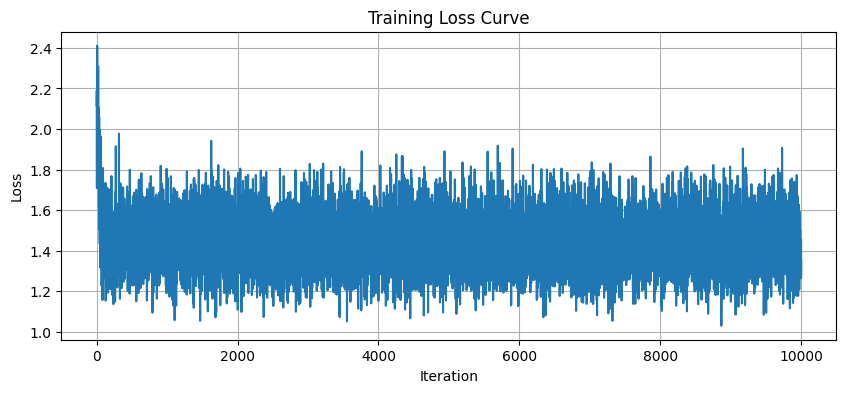

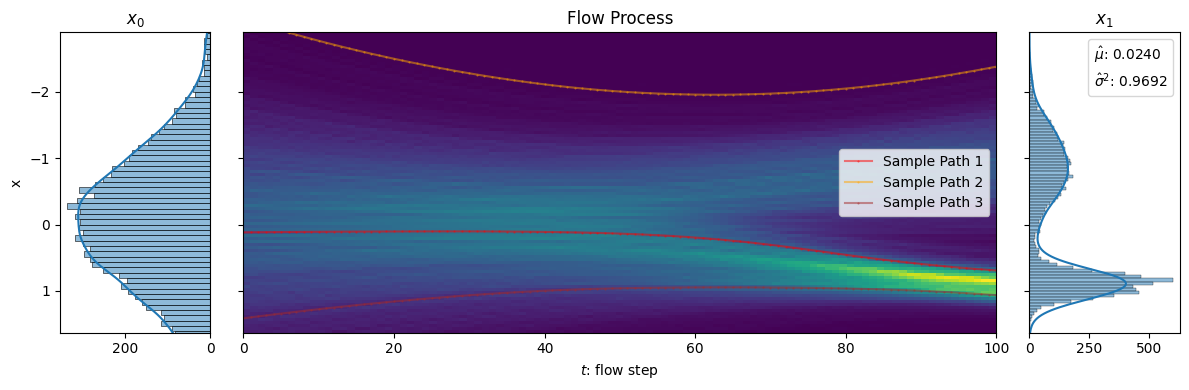

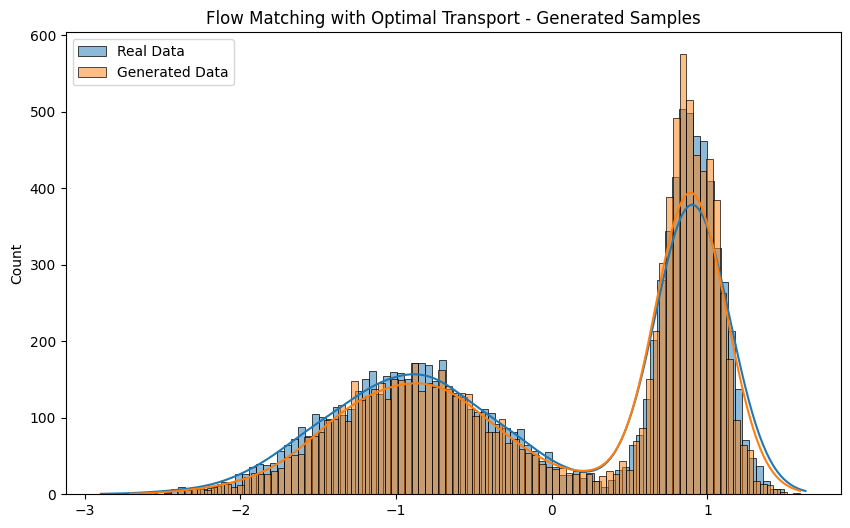

In [1]:
"""
Minimal PyTorch implementation of Flow Matching with Optimal Transport (OT) for generative modeling of a 1D bimodal Gaussian distribution, based on "Flow Matching for Generative Modeling" by Lipman et al. (2023).

This code provides a simplified example using a 1D bimodal Gaussian dataset and Euler method for sampling. It includes a visualization of the flow paths.
"""

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from typing import Tuple

# Device configuration
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
data_size: int = 10_000
batch_size: int = 256
input_dim: int = 1  # 1D data
hidden_dim: int = 64
n_iterations: int = 10_000
sigma_min: float = 1e-5  # For OT path (Eq. 22). Controls variance at t=1
lr: float = 1e-3
dt: float = 0.01  # Step size for Euler integration (sampling and flow visualization). Smaller dt => smoother curves and longer computation time.
n_flow_steps = int(1 / dt)

# Data #######################################################################
# Generate 1D bimodal Gaussian data (replace with your data loading if needed).
nb_samples = data_size
mode_prob = np.array([0.5, 0.5])  # Mixture weights
mode_mus = np.array([-10.0, 10.0])  # Means of the two Gaussian modes
mode_sigmas = np.array([6.0, 2.0])  # Standard deviations of the modes
mode_idx = np.random.choice(2, nb_samples, p=mode_prob)
data_x_1_arr = np.random.normal(loc=mode_mus[mode_idx], scale=mode_sigmas[mode_idx])
# Normalize data (important for training stability)
data_x_1_arr = (data_x_1_arr - data_x_1_arr.mean()) / data_x_1_arr.std()
data_x_1 = (
    torch.tensor(data_x_1_arr, dtype=torch.float32).unsqueeze(-1).to(device)
)  # Add dimension for consistency with model.  Unsqueeze last dimension to get shape [data_size, 1].

data_loader = torch.utils.data.DataLoader(data_x_1, batch_size=batch_size, shuffle=True)

# Plot data distribution. This is the TARGET distribution (π₁)
fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)
sns.histplot(data_x_1_arr, bins=100, kde=True, ax=ax)
ax.set_title("Target Data Distribution (π₁)")
ax.set_xlabel("x")
plt.show()


# Model and Training ##########################################################
class VectorFieldNetwork(nn.Module):
    """
    Parametric model for the time-dependent vector field v_t(x; θ) (Section 3 in Lipman et al.).

    This network represents the function v_t(x; θ), which is the Continuous Normalizing Flow (CNF) vector field.
    It is used in the Flow Matching objective (Eq. 5 in Lipman et al.).
    The network outputs the *value* of the vector field at a given time t and point x.
    """

    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        # MLP architecture (no specific architecture defined in the paper)
        self.net: nn.Sequential = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for time embedding
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def time_embedding(self, t: torch.Tensor) -> torch.Tensor:
        """
        Embeds time into a higher dimensional space.
        """
        return t.unsqueeze(-1)  # Simple embedding, no frequencies used

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Computes the vector field v_t(x) at time t and point x.
        """
        t_emb: torch.Tensor = self.time_embedding(t)
        tx: torch.Tensor = torch.cat([t_emb, x], dim=-1)
        return self.net(tx)  # Output is v_t(x; θ) (Eq. 5 in Lipman et al.)


def ot_path(
    x_0: torch.Tensor,
    x_1: torch.Tensor,
    t: torch.Tensor,
    sigma_min: float,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes the Optimal Transport (OT) path (ψ_t) and target vector field (u_t).

    This function implements the conditional flow ψ_t (Eq. 22 in Lipman et al.) and the corresponding target vector field u_t (Eq. 23 in Lipman et al.) for the Optimal Transport (OT) formulation in Flow Matching.  ψ_t defines a straight-line interpolation path between a sample x_0 from the prior distribution and a target data point x_1.  The target vector field u_t represents the ideal vector field that the learned vector field v_t should approximate.

    Args:
        x_0: Samples from the prior distribution (typically a standard Gaussian).
        x_1: Target data points.
        t: Time points along the OT path (between 0 and 1).
        sigma_min: Small constant controlling the variance at t=1 (see Eq. 22).

    Returns:
        A tuple containing the OT path (ψ_t) and the target vector field (u_t).
    """
    t = t.unsqueeze(-1)
    # ψ_t (Eq. 22 in Lipman et al.) Linear interpolation between prior and target.
    psi_t: torch.Tensor = (1 - (1 - sigma_min) * t) * x_0 + (t * x_1)
    # Target vector field for OT (u_t) (Eq. 23 in Lipman et al.)
    target_v: torch.Tensor = x_1 - (1 - sigma_min) * x_0
    return psi_t, target_v


def compute_cfm_loss(
    v_net: VectorFieldNetwork,
    x_0: torch.Tensor,
    x_1: torch.Tensor,
    t: torch.Tensor,
    sigma_min: float,
) -> torch.Tensor:
    """
    Computes the Conditional Flow Matching (CFM) loss for Optimal Transport.

    This function computes the CFM loss (Eq. 23 in Lipman et al.) using the Optimal Transport (OT) formulation.  It compares the predicted vector field v_t(ψ_t(x_0, x_1, t)) (output of the v_net) with the target vector field u_t derived from the OT path. The loss is calculated as the mean squared error (MSE) between the predicted and target vector fields.  Minimizing this loss encourages the learned vector field to accurately represent the OT flow.

    Args:
        v_net: The vector field network v_t(x; θ).
        x_0: Samples from the prior distribution.
        x_1: Target data points.
        t: Time points along the OT path.
        sigma_min: Small constant controlling the variance at t=1.

    Returns:
        The CFM loss as a scalar tensor.
    """
    psi_t, target_v = ot_path(x_0, x_1, t, sigma_min)
    v: torch.Tensor = v_net(t, psi_t)  # v_t(ψ_t(x_0, x_1, t))
    # CFM loss (Eq. 23 in Lipman et al.), simplified as MSE loss
    loss: torch.Tensor = ((v - target_v) ** 2).mean()
    return loss


# Initialize the vector field network v_t and optimizer
v_net = VectorFieldNetwork(input_dim, hidden_dim).to(device)
optimizer = optim.Adam(v_net.parameters(), lr=lr)

# Training loop
progress_bar = tqdm(range(n_iterations), desc="Training", unit="iteration")
losses = []
for iteration in progress_bar:
    x_1 = next(iter(data_loader))
    t = torch.rand(x_1.shape[0], device=device)
    x_0 = torch.randn_like(x_1)

    loss = compute_cfm_loss(v_net, x_0, x_1, t, sigma_min)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

# Plot loss curve after training
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(losses)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("Training Loss Curve")
ax.grid(True)
plt.show()


# Sampling and Visualization ##################################################
def sample(
    n_samples: int, vector_field: VectorFieldNetwork, dt: float = dt
) -> torch.Tensor:
    """
    Generates samples by integrating the learned vector field.

    This function generates samples by numerically integrating the learned vector field `v_t(x)` from t=0 to t=1.  It uses the Euler method (a simple first-order numerical integration method) to approximate the solution to the ODE defined by the vector field (Eq. 1 in Lipman et al. with a simplified discretization).  The integration starts from random samples drawn from the prior distribution (typically a standard Gaussian).

    Args:
        n_samples: The number of samples to generate.
        vector_field: The learned vector field network v_t(x; θ).
        dt: The integration step size.

    Returns:
        A tensor of generated samples.
    """
    x = torch.randn(n_samples, input_dim).to(device)  # Sample x_0 ~ N(0, I)
    for t in torch.arange(0, 1, dt):  # Euler integration from t=0 to t=1
        t_batch = t.expand(n_samples).to(device)
        # Euler update (Eq. 28 in Lipman et al. with simplified discretization)
        x = x + vector_field(t_batch, x) * dt
    return x


def plot_flow_process(
    data_x_1: torch.Tensor,
    v_net: VectorFieldNetwork,
    n_samples: int = 10_000,
    n_example_paths: int = 3,
):
    """
    Plot the flow process using the trained vector field network.

    This function visualizes the transformation of samples from the initial noise distribution
    to the target distribution, using the learned vector field.

    Args:
        data_x_1 (torch.Tensor): The target data distribution.
        v_net (VectorFieldNetwork): The trained vector field network.
        n_samples (int): Number of samples to use for visualization.
        n_example_paths (int): Number of example paths to plot.

    Returns:
        tuple: A tuple containing the figure and axes objects.
    """
    # Generate initial noise samples
    x_0 = torch.randn(n_samples, input_dim).to(device)  # Initial noise distribution

    # Initialize tensor to store the flow process
    paths = torch.zeros((n_flow_steps + 1, n_samples, input_dim), device=device)
    paths[0] = x_0

    # Set up histogram parameters
    img_hist_size = 100
    flow_process_img = np.zeros((n_flow_steps + 1, img_hist_size))
    x_min, x_max = data_x_1.cpu().min().item(), data_x_1.cpu().max().item()
    histogram_edges = np.linspace(x_min, x_max, img_hist_size + 1)

    # Add the histogram of the initial distribution
    flow_process_img[0] = np.histogram(x_0.cpu().numpy(), bins=histogram_edges)[0]

    # Generate the flow process
    with torch.no_grad():
        for i in range(n_flow_steps):
            t = torch.full((n_samples,), i * dt, device=device)
            # Update samples using the vector field (Euler integration step)
            paths[i + 1] = paths[i] + v_net(t, paths[i]) * dt
            # Compute histogram for current step
            flow_process_img[i + 1] = np.histogram(
                paths[i + 1].cpu().numpy(), bins=histogram_edges
            )[0]

    paths = paths.cpu().numpy().squeeze()

    # Set up the plot
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(12, 4), gridspec_kw={"width_ratios": [1, 5, 1]}, sharey=True
    )
    fig.subplots_adjust(wspace=0)

    # Plot the flow process
    ax2.set_title("Flow Process")
    ax2.imshow(
        flow_process_img.T,
        extent=[0, n_flow_steps, x_max, x_min],
        aspect="auto",
        cmap="viridis",
    )
    ax2.set_ylim(x_max, x_min)
    ax2.set_xlabel("$t$: flow step")

    # Plot example paths, each in a different color
    tab_colors = [
        "red",
        "orange",
        "brown",
        "pink",
        "gray",
        "cyan",
        "magenta",
    ]  # Avoid blue, green, and yellow
    for i in range(n_example_paths):
        ax2.plot(
            np.arange(0, n_flow_steps + 1),
            paths[:, i],
            marker=".",
            linestyle="-",
            color=tab_colors[i % len(tab_colors)],
            label=f"Sample Path {i+1}",
            markersize=1,
            alpha=0.5,
        )
    ax2.legend()

    # Plot initial distribution x0
    ax1.set_title("$x_0$")
    sns.histplot(
        y=x_0.cpu().numpy().flatten(),
        bins=img_hist_size,
        kde=True,
        color="tab:blue",
        ax=ax1,
    )
    ax1.invert_xaxis()
    ax1.set_ylabel("x")
    ax1.set_xlabel("")

    # Plot final distribution x1
    ax3.set_title("$x_1$")
    sns.histplot(y=paths[-1], bins=img_hist_size, color="tab:blue", kde=True, ax=ax3)
    ax3.set_xlabel("")
    x1_mean = paths[-1].mean()
    x1_std = paths[-1].std()
    ax3.legend(
        handles=[
            plt.Line2D([], [], label=f"$\hat{{\mu}}$: {x1_mean:.4f}"),
            plt.Line2D([], [], label=f"$\hat{{\sigma}}^2$: {x1_std:.4f}"),
        ],
        handlelength=0,
        handletextpad=0,
        alignment="right",
    )

    plt.tight_layout()
    plt.show()
    return fig, (ax1, ax2, ax3)


# Sample and plot generated data, and plot flow process
with torch.no_grad():
    generated_samples = sample(data_size, v_net)
generated_samples = generated_samples.cpu().numpy()

plot_flow_process(data_x_1, v_net)

# Visualization of real vs generated data
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=data_x_1_arr, bins=100, kde=True, label="Real Data", ax=ax)
sns.histplot(
    data=generated_samples.flatten(), bins=100, kde=True, label="Generated Data", ax=ax
)
ax.set_title("Flow Matching with Optimal Transport - Generated Samples")
ax.legend()
plt.show()